# ContinuumWorld
This notebook demonstrates some of the global policy features of AdaStress.

In [1]:
using AdaStress
import AdaStress.GrayBox
using BSON
using Distributions
using Random

┌ Info: Precompiling AdaStress [f8632b6a-8763-4da0-bfaf-5f7707adef25]
└ @ Base loading.jl:1317


## Pawn

In [2]:
Base.@kwdef mutable struct Initialization
    x::Distribution = Uniform(0, 10)
    y::Distribution = Uniform(0, 10)
end

Base.@kwdef mutable struct Pawn
    x::Float64 = 0.0
    y::Float64 = 0.0
end

vec(pawn::Pawn) = [pawn.x, pawn.y]

observation(pawn::Pawn) = vec(pawn) / 10.0 # normalized state

function initialize(pawn::Pawn, init::Initialization)
    pawn.x = rand(init.x)
    pawn.y = rand(init.y)
end

function update(pawn::Pawn, Δx::Float64, Δy::Float64)
    pawn.x += Δx
    pawn.y += Δy
end

update (generic function with 1 method)

## Disturbance and failure models

In [3]:
Base.@kwdef mutable struct Disturbance
	x::Distribution = Normal(0.0, 0.25)
	y::Distribution = Normal(0.0, 0.25)
end

Base.@kwdef mutable struct FailureZone
	x::Float64 = 0.0
	y::Float64 = 0.0
	r::Float64 = 0.0
end

Base.in(pawn::Pawn, zone::FailureZone) = (pawn.x - zone.x)^2 + (pawn.y - zone.y)^2 <= zone.r^2

distance(pawn::Pawn, zone::FailureZone) = max(sqrt((pawn.x - zone.x)^2 + (pawn.y - zone.y)^2) - zone.r, 0.0)

distance (generic function with 1 method)

## Metrics

In [4]:
Base.@kwdef mutable struct Metrics
    d::Float64 = 0.0
	in_zone::Bool = false
end

const Log = Dict{String, Any}

function initialize(m::Metrics, pawn::Pawn, zone::FailureZone)
	update(m, pawn, zone)
end

function update(m::Metrics, pawn::Pawn, zone::FailureZone)
    m.d = distance(pawn, zone) 
	m.in_zone = pawn in zone
end

update (generic function with 2 methods)

## Simulator

In [5]:
Base.@kwdef mutable struct Simulator <: AdaStress.GrayBox
	t::Float64 = 0.0
	t_max::Float64 = 50.0
	pawn::Pawn = Pawn()
	init::Initialization = Initialization()
	disturbance::Disturbance = Disturbance()
	zone::FailureZone = FailureZone(7, 3, 1)
	metrics::Metrics = Metrics()
    env::AdaStress.Environment = AdaStress.Environment()
    log::Log = Log()
    logging::Bool = false
    rand_time::Bool = true
end

function initialize(sim::Simulator)
	sim.t = sim.rand_time ? rand() * sim.t_max : 0.0
	initialize(sim.pawn, sim.init)
	initialize(sim.metrics, sim.pawn, sim.zone)
    sim.env[:Δx] = sim.disturbance.x
    sim.env[:Δy] = sim.disturbance.y
    initialize(sim.log, sim)
    return
end

function update(sim::Simulator, value::AdaStress.EnvironmentValue)
	sim.t += 1.0
	update(sim.pawn, value[:Δx], value[:Δy])
	update(sim.metrics, sim.pawn, sim.zone)
	update(sim.log, sim)
	return
end

update (generic function with 3 methods)

## Logging

In [6]:
function initialize(log::Log, sim::Simulator)
    sim.logging || return
    log["t"] = [sim.t]
    log["pawn"] = [vec(sim.pawn)]
    log["d"] = [sim.metrics.d]
    log["in_zone"] = [sim.metrics.in_zone]
end

function update(log::Log, sim::Simulator)
    sim.logging || return
    push!(log["t"], sim.t)
    push!(log["pawn"], vec(sim.pawn))
    push!(log["d"], sim.metrics.d)
    push!(log["in_zone"], sim.metrics.in_zone)
end

save(log::Log, filename::String) = BSON.@save filename * ".bson" log

save (generic function with 1 method)

## Interface setup

In [7]:
Interface.reset!(sim::Simulator) = initialize(sim)

Interface.environment(sim::Simulator) = sim.env

Interface.observe(sim::Simulator) = vcat(observation(sim.pawn), sim.t / sim.t_max)

Interface.step!(sim::Simulator, x::AdaStress.EnvironmentValue) = update(sim, x)

Interface.isterminal(sim::Simulator) = sim.t >= sim.t_max

Interface.isevent(sim::Simulator) = sim.metrics.in_zone

Interface.distance(sim::Simulator) = sim.metrics.d

## Solver

In [8]:
using AdaStress.SoftActorCritic

In [9]:
function mdp_env(; kwargs...)
    mdp = Interface.ASTMDP(Simulator(; kwargs...))
    mdp.reward.event_bonus = 100.0
    return mdp
end

mdp_env (generic function with 1 method)

In [10]:
Random.seed!(0)
sac = SAC(;
    obs_dim=3, 
    act_dim=2,
    gamma=1.0,
    act_mins=-3.0*ones(2),
    act_maxs=3.0*ones(2),
    hidden_sizes=[30,30,30],
    num_q=3,
    max_buffer_size=1000000,
    batch_size=1024,
    epochs=25, # low value for testing only; set to >25 to see learning
    steps_per_epoch=1000,
    start_steps=10000,
    max_ep_len=50,
    update_after=10000,
    update_every=1000,
    num_test_episodes=100,
    displays=[(:fails, mdp -> mdp.sim.metrics.in_zone)],
)

SAC(3, 2, [-3.0, -3.0], [3.0, 3.0], 1.0, 1000000, AdaStress.Solvers.SoftActorCritic.ReplayBuffer(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1, 0, 1000000), [30, 30, 30], 3, AdaStress.Solvers.SoftActorCritic.relu, Flux.Optimise.AdaBelief(0.0001, (0.9, 0.999), IdDict{Any, Any}()), Flux.Optimise.AdaBelief(0.0001, (0.9, 0.999), IdDict{Any, Any}()), Flux.Optimise.AdaBelief(0.0001, (0.9, 0.999), IdDict{Any, Any}()), 1024, 25, 1000, 10000, 50, 10000, 1000, 1000, 0.995, -2.0, Random._GLOBAL_RNG(), 100, [(:fails, var"#8#9"())], false, 10000, "C:\\Users\\rlipkis\\.julia\\dev\\AdaStress\\src\\solvers\\global\\sac\\checkpoints", 100)

In [11]:
SoftActorCritic.ProgressMeter.ijulia_behavior(:clear)
ac, info = sac(mdp_env);

Progress: 100%|█████████████████████████████████████████| Time: 0:06:39
  epoch:  25
  score:  52.044308
  stdev:  1.550271
  fails:  0.64


## Analysis

In [12]:
using AdaStress.PolicyValueVerification

In [13]:
network = mean_network(ac; act_mins=-3*ones(2), act_maxs=3*ones(2))

AdaStress.Analysis.PolicyValueVerification.ExtendedNetwork(NeuralVerification.Network(NeuralVerification.Layer[NeuralVerification.Layer{NeuralVerification.Id, Float32}(Float32[1.0 0.0 0.0; 0.0 1.0 0.0; … ; 0.0 1.0 0.0; 0.0 0.0 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], NeuralVerification.Id()), NeuralVerification.Layer{NeuralVerification.ReLU, Float32}(Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … -0.11553229 0.17170867; 0.0 0.0 … 0.31007528 0.41716018], Float32[0.0, 0.0, 0.0, 0.094314836, 0.024035968, 0.19182974, 0.055642534, 0.084353626, 0.27463162, -0.09582514  …  0.056805965, 0.35057336, -0.026769323, 0.0, -0.03431834, 0.40903527, -0.06576733, -0.087135956, 0.18408123, -0.027145382], NeuralVerification.ReLU()), NeuralVerification.Layer{NeuralVerification.ReLU, Float32}(Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 0.040356126 0.074247815; 0.0 0.0 … 0.2578884 0.07735276], Float32[0.0, 0.0, 0.0, -0.10707438, 0.100440376, -0.14985283, 0.14465766, 0.007608

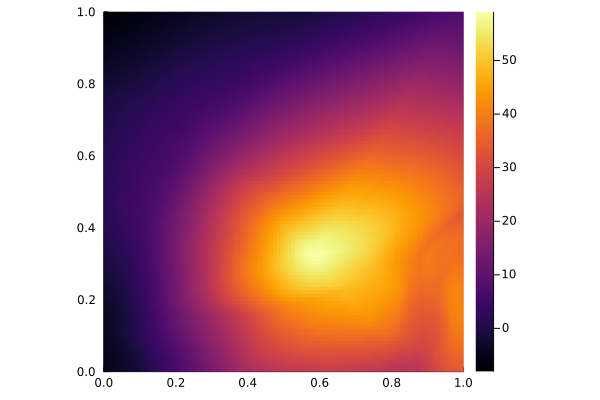

In [14]:
cs = CrossSection([:x1, :x2, 0.9])
limits = ([0.0, 0.0], [1.0, 1.0])
p = PolicyValueVerification.visualize(network, cs, limits)

In [15]:
nnet = cross_section(network, cs, limits)
midpoint_value = AdaStress.Analysis.PolicyValueVerification.compute_output(nnet, mean(limits))[]

36.352263713690235

In [16]:
r = BinaryRefinery(network=nnet, val=midpoint_value, tol=0.01)
root = get_root(limits)
@time refine!(root, r)

 45.378599 seconds (230.38 M allocations: 95.904 GiB, 15.61% gc time, 9.65% compilation time)


In [17]:
@show num_leaves(root)
@show coverage(root)
@show coverage(root, true)
@show coverage(root, false)

num_leaves(root) = 442
coverage(root) = 0.959228515625
coverage(root, true) = 0.732177734375
coverage(root, false) = 0.22705078125


0.22705078125

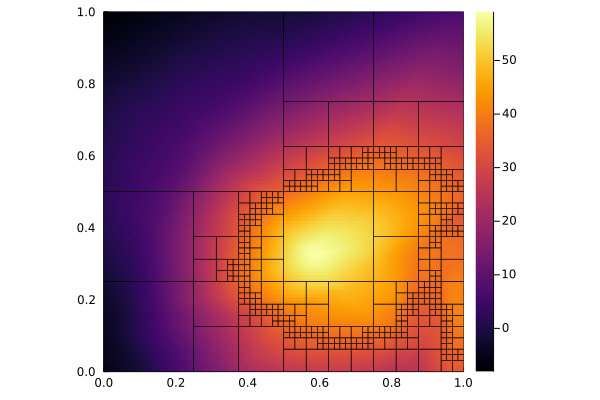

In [18]:
visualize!(deepcopy(p), root)

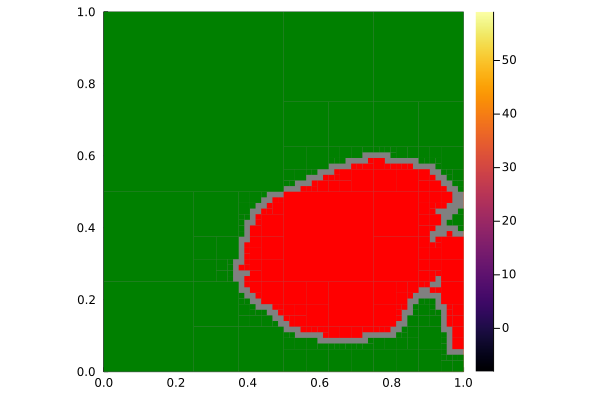

In [19]:
visualize!(deepcopy(p), root; fill=true)